In [1]:
import numpy as np
import math
from scipy import spatial
import random
from random import randrange
from scipy.stats import powerlaw
from scipy import stats
import csv
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from apgl.graph import *
from apgl.generator.KroneckerGenerator import KroneckerGenerator
from apgl.io.SimpleGraphWriter import SimpleGraphWriter

Creating the Kornecker Graph using a python Graph Library [APGL](https://pythonhosted.org/apgl/KroneckerGenerator.html). This kronecker graph has 25 nodes, so it will generate a 25 by 25 lattice

Now we are trying to create a 2d lattice using the underlying adjacency matrix created from the Kronecker graph we have just created. To do so we will first export the edges of the graph, then import them into a networkx undirected graph and get the Adjacency matrix from the networkx graph

In [2]:
with open('./edgeList.txt', 'r') as f:
    content = f.readlines()
    start = False
    coordinates = list()
    for line in content:
        if start:
            coordinates.append(line.strip().split(','))
        if line=="Edges\n":
            start = True

G = nx.Graph()

with open('coords.csv', 'wb') as f:
    writer = csv.writer(f, delimiter=' ')
    for coordinate in coordinates:
        edge = list([int(coordinate[0]),int(coordinate[1])])
        writer.writerow([int(coordinate[0]),int(coordinate[1])])
        G.add_edge(*edge)
        
x = nx.to_numpy_matrix(G)

We are checking if the graph is connected or not. If the graph is not connected then there could be some nodes that are unreachable from another node, becuase somtimes the shortcuts are even further from target node compared to regular adjacent links.

In [3]:
nx.is_connected(G)

False

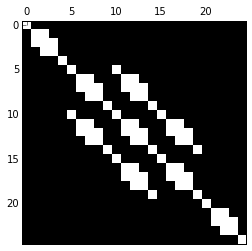

In [4]:
plt.figure(figsize=(12,12))
plt.matshow(x,cmap=plt.cm.gray)
plt.show()

Now we are trying the greedy routing from a randomly selected source and a target. This is the algorithm:
- We randomly sample co-ordinates of a source node and a traget node in the 2d lattice. If the value in the adjacency matrix of the randomly sampled nodes are not 1 then we sample the nodes until its value is 1, because the points whose value is 0 in the adjacency matrix are the empty points.

- Then for each value of $\alpha$ we run a greedy routing from each node. As we have already chosen a lattice whose vertices are conncted, we traverse from the source nodes and target nodes. For each timestep we have a current node, who has neighbours on top, bottom, right, left for which the number of steps is 1, and we have the corner neighbors e.g. top-right, top-left, bottom-right and bottom-left, for which the number of step is 2. We only have neigbors if there value in the kronecker adjacency matrix is 1. We also find a shortcut neighbor which is sampled using a power  law distribution using $\alpha$ parameter. If the shortcut neighbor sampled has a value 0 in the adjacency matrix then we sample again until we find a neihbor that has a value of 1 in the adjacency matrix we derive from the kronecker graph.

- We try all the neighbors to take a step. We proceed towards the neighbor that is closest to the target. If we take a step to any of the corner neighbors, we count it as a 2-step movement as we are counting the distance using manhattan distance.

- We count the number of steps it takes to go to the neighbor.

- We run this algortihm 200 times and get the average steps taken from randomly sampled source and target node for each $\alpha$

In [5]:
edgelist = dict()
dist = dict()

f_out = open("results_kleinberg_final25by25.txt","w")

dim = 25
distances = dict()

output_map = defaultdict(list)




def truncated_power_law(a, m):
    x = np.arange(1, m+1, dtype='float')
    ## Why alpha - 1
    pmf = 1/x**(a-1)
    pmf /= pmf.sum()
    return stats.rv_discrete(values=(range(1, m+1), pmf))

for net in range(400):
    if net%10==0:
        print net
    si = random.sample(range(dim),1)[0]
    sj = random.sample(range(dim),1)[0]
    while x[si,sj] < 1:
        si = random.sample(range(dim),1)[0]
        sj = random.sample(range(dim),1)[0]
    ti = random.sample(range(dim),1)[0]
    tj = random.sample(range(dim),1)[0]

    while x[ti,tj] < 1:
        ti = random.sample(range(dim),1)[0]
        tj = random.sample(range(dim),1)[0]
    #print "source si-sj", si, sj
    #print "target ti-tj", ti ,tj
    for q1 in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5]:
        #print "current q1", q1
        last_nodes = [None]*2
        recur = 0

        cstm = truncated_power_law(q1,23)
        l = 0
        current = str(si)+"-"+str(sj)
        #print "current source",current
        while (current != str(ti)+"-"+str(tj) and l <= dim*2):
            d_min = 1000
            edgelist[current] = []
            ii = int(current.split("-")[0])
            ij = int(current.split("-")[1])
            if ii < dim-1:
                if x[ii+1,ij] > 0:
                    edgelist[str(ii)+"-"+str(ij)].append([str(ii+1)+"-"+str(ij),1])
                if ij < dim -1:
                    if x[ii+1,ij+1] > 0:
                        edgelist[str(ii)+"-"+str(ij)].append([str(ii+1)+"-"+str(ij+1),2])
                if ij > 0:
                    if x[ii+1,ij-1] > 0:
                        edgelist[str(ii)+"-"+str(ij)].append([str(ii+1)+"-"+str(ij-1),2])
            if ij < dim-1:
                if x[ii,ij+1] > 0:
                    edgelist[str(ii)+"-"+str(ij)].append([str(ii)+"-"+str(ij+1),1])
                if ii > 0:
                    if x[ii-1,ij+1] > 0:
                        edgelist[str(ii)+"-"+str(ij)].append([str(ii-1)+"-"+str(ij+1),2])
            if ii > 0:
                if x[ii-1,ij] > 0:
                    edgelist[str(ii)+"-"+str(ij)].append([str(ii-1)+"-"+str(ij),1])
                if ij > 0:
                    if x[ii-1,ij-1] > 0:
                        edgelist[str(ii)+"-"+str(ij)].append([str(ii-1)+"-"+str(ij-1),2])
            if ij > 0:
                if x[ii,ij-1] > 0:
                    edgelist[str(ii)+"-"+str(ij)].append([str(ii)+"-"+str(ij-1),1])

            #print "edgelist without shortcut",edgelist
            no_shortcuts = 1
            ## What is d_max ??
            d_max = 1
            shortcut_found = False
            while not shortcut_found:
                for shortcuts in range(no_shortcuts):
                    r_sample = cstm.rvs()
                    #print "r_sample", r_sample
                    if (math.floor(r_sample*d_max) > 1):
                        k = random.sample(range(int(math.floor(r_sample*d_max))),1)[0]
                        #print "k", k
                        k1 = k
                        k2 = math.floor(r_sample*d_max) - k1
                        #print "k1, k2", k1, k2
                        ni = []
                        nj = []
                    if (ii + k1 <= dim-1) and (ij + k2 <= dim-1):
                        if x[ii + k1,ij + k2] > 0:
                            ni.append(ii + k1)
                            nj.append(ij + k2)
                    if (ii + k1 <= dim-1) and (ij - k2 >= 0):
                        if x[ii + k1,ij - k2] > 0:
                            ni.append(ii + k1)
                            nj.append(ij - k2)
                    if (ii - k1 >= 0) and (ij + k2 <= dim-1):
                        if x[ii - k1,ij + k2] > 0:
                            ni.append(ii - k1)
                            nj.append(ij + k2)
                    if (ii - k1 >= 0) and (ij - k2 >= 0):
                        if x[ii - k1,ij - k2] > 0:
                            ni.append(ii - k1)
                            nj.append(ij - k2)
                    #print "ni-nj" ,ni , nj
                    if ni != []:
                        k = random.sample(range(len(ni)),1)[0]
                        edgelist[current].append([str(int(ni[k]))+"-"+str(int(nj[k])),1])
                        shortcut_found = True
            #print "with shortcut", edgelist
            for p, footstep in edgelist[current]:
                pi = p.split("-")[0]
                pj = p.split("-")[1]
                if spatial.distance.cityblock(np.array([ti,tj]),np.array([int(pi),int(pj)])) < d_min:
                    d_min = spatial.distance.cityblock(np.array([ti,tj]),np.array([int(pi),int(pj)]))
                    tempi = pi
                    tempj = pj
                    temp_footstep = footstep
            current = tempi.rstrip()+"-"+tempj.rstrip()


            #print "next node is", current, "temp_footstep is", temp_footstep
            l = l + temp_footstep
            #print "current l", l
        #print "final l", l
        print >> f_out, q1, l, si, sj, ti, tj
        output_map[q1].append(l)

f_out.close()

0
10
20
30
40
50


KeyboardInterrupt: 

The fractal dimension for the embedding lattice is, fd = 1.135. Now we are plotting the log of average steps taken vs the $\alpha$ values.

In [ ]:
output_for_plot = {n: sum(output_map[n])/float(len(output_map[n])) for n in output_map.keys()}
plt.figure(figsize=(10,10))
plt.plot(output_for_plot.keys(), np.log(output_for_plot.values()), 'ro')
plt.title("")
plt.ylabel("ln T for the greedy algorithm")
plt.xlabel(r"Clustering Exponent $\alpha$")
plt.xticks(np.arange(0,2.6,0.2))
plt.show()